This notebook provides code to map the change in hadley cells through time. Specifically for SH summer months (DJF) from 1871 to 2017 the extent of the hadley cell will be mapped. The definition of hadley cells will remain constant through time. Then each of these cells will be mapped on top of each other. 

Procedure: 
    1. Read netCDF file containing vwnd since 1871
    2. Filter DJF 
    3. Combine Seasons 
    4. Obtain HC extent mask for each year 
    5. Plot years 

In [1]:
 lib
import plotly
import netCDF4 as nc
from sklearn.cluster import DBSCAN
import pandas as pd

import matplotlib.pyplot as plt
import plotly.plotly as py 
import plotly.tools as tls
from plotly.graph_objs import * 

import numpy as np 
from scipy.io import netcdf 
from scipy.stats import pearsonr
from mpl_toolkits.basemap import Basemap

plotly.tools.set_credentials_file(username='ncresswell', api_key='XVFWb00wZKWyDJTrB2Dl')

%load_ext autoreload
%autoreload 2

In [52]:
#################################################################
#############      define useful variables       ################
#################################################################

#reference points for defining various cells 
s_atlantic_ref = [-22.5,14.4]
s_pacific_ref  = [-17.5,-75.5]
s_indian_ref   = [-26.14, 113.15]
n_atlantic_ref = [21.5, -16]
n_pacific_ref  = [38, -123]

#specify useful variables before running 
filename = 'C:\\Users\\Nathaniel\\Desktop\\Summer2018\\HC_Summer2018\\Data\\vwnd.mon.mean.nc'
alt = 1000 
hadley_threshold = 4
binning = 'yes'
#define clustering data
db_epsilon     = 4.7
db_min_samples = 4

#which cell? 
ref = s_indian_ref

In [22]:
#################################################################
#############      define useful functions       ################
#################################################################

#see_file_data will receive a file with its path as a string and print information about the file...thie file must be net cdf 
#              will not return anything 
def see_file_data(path):
    temp = nc.Dataset(filename,'r')
    print('FILENAME: ', filename, '\n','\n')
    print('FILE HEADER: ', '\n', temp,'\n','\n')
    print('FILE VARIABLES: ','\n',temp.variables)

    return

#fix_lon will be given a data array and a longitude array 
#        will return arrays of longitude and data that have been reformatted
def fix_lon(array_to_fix, lon_of_array):
    
    #make longitude from -180 to 180 degrees east 
    tmp_lon = lon_of_array
    for n in range (tmp_lon.size):
        if tmp_lon[n]>180:
            tmp_lon[n] = lon_of_array[n]-360

    #reorient data to be centered at 0 degrees east 
    i_west    = np.where(tmp_lon<0)
    i_east    = np.where(tmp_lon>0)
    west      = tmp_lon[i_west]
    east      = tmp_lon[i_east]
    fixed_lon = np.array(np.hstack((west,east)))
    
    #make similar adjustments so that vwnd matches new longitude 
    vwnd_west   = np.squeeze(array_to_fix[:,:,i_west])
    vwnd_east   = np.squeeze(array_to_fix[:,:,i_east])
    fixed_array = np.concatenate((vwnd_west,vwnd_east), axis=2)
        
    return fixed_array,fixed_lon

#read_nc_file will be given the path to a netcdf file
#             will return an array of time, level, lat, lon, data
#                  >lon, lat and data will be adjusted so lon is from -180 to 180 degrees east, lat is 0 to 360 degrees north
def read_nc_file( filename ):
    
    print('Reading netCDF file...')
    
    #extract lon, lat, level and data stored in the netCDF file specified 
    with nc.Dataset(filename,'r') as f:
        lon   = f.variables['lon'][::]
        lat   = f.variables['lat'][::-1]
        time  = f.variables['time'][::]
        level = f.variables['level'][::]
        temp0 = f.variables['vwnd'][:,:,::-1,:]

    #find index of appropriate pressure 
    index = np.where(level == alt)
    
    temp1 = temp0[:,index,:,:]
    vwnd  = temp1.squeeze()
      
    vwnd,lon = fix_lon(vwnd,lon)
    
    return time, level, lat, lon, vwnd

#find_DJF_JJA will take an array of data and an array of 
#             will return 3D arrays of DJF and JJA arrays ----> Assumes Jan start 
def find_DJF_JJA(array_to_parse):
                
    DJF  = np.array([])
    JJA  = np.array([])
    
    for n in range (0,array_to_parse.shape[0]):
        
        temp = None
        
        if (np.mod(n,12)==1 or np.mod(n,12)==11 or np.mod(n,12)==0):
                      
            if (DJF.size==0):
                DJF  = array_to_parse[n,:,:]
                DJF  = DJF.reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
            else:
                temp = array_to_parse[n,:,:].reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
                DJF  = np.concatenate((DJF,temp),0)
   
        if (np.mod(n,12)==5 or np.mod(n,12)==6 or np.mod(n,12)==7):
            if (JJA.size==0):
                JJA  = array_to_parse[n,:,:]
                JJA  = JJA.reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
            else:
                temp = array_to_parse[n,:,:].reshape(1,array_to_parse.shape[1],array_to_parse.shape[2])
                JJA  = np.concatenate((JJA,temp),0)
        temp = None

    return DJF,JJA

#find_clusters_labels will receive matrix of mean wind data
#                     will return points that have been clustered (using density-base clustering) and their respective labels 
def find_clusters_labels(data):
    
    print('finding clusters with epsilon: ', db_epsilon,' for ', db_min_samples, ' minimum samples with threshold of ', hadley_threshold,'...')
    
    mask_coordinates = np.empty([2,1])
    
    first_element = True
    
    for n in range(0,data.shape[0]):
        for m in range(0, data.shape[1]):
            if np.absolute(data[n,m])>hadley_threshold:
                temp = np.array([[lat[n]],[lon[m]]])
                if first_element: 
                    mask_coordinates = temp 
                    first_element = False 
                else: 
                    mask_coordinates = np.append(mask_coordinates,temp,1)
    
    mask_coordinates = np.transpose(mask_coordinates)
    db = DBSCAN(eps=db_epsilon, min_samples=db_min_samples).fit(mask_coordinates)
    
    return mask_coordinates, db.labels_

#bin_years takes an array and years per bin and returns information from the array binned into the indicated number of bins
def bin_years(array,ypb):
    
    #determine number of bins 
    nbins = np.floor_divide(array.shape[0],ypb)+1
    #initialize binned array
    binned_array = np.empty([nbins,array.shape[1],array.shape[2]])
    print('Num Bins: ',nbins)
    print('Years Per Bin: ',ypb,'\n')
    for i in range(0,nbins-1):
        
        temp_0 = np.empty([ypb,array.shape[1],array.shape[2]])
        print('filling bin ',i,' with: ')
        for j in range(0,ypb):
            print('      array[',(i*ypb)+j,',:,:]')
            temp_0[j,:,:] = array[(i*ypb)+j,:,:]
            
        binned_array[i,:,:]=np.mean(temp_0,axis=0)
    
    
    temp_1 = np.empty([np.remainder(array.shape[0],ypb),array.shape[1],array.shape[2]])
    print('\n',np.remainder(array.shape[0],ypb),' years remaining...','\n' )
    print('filling bin ',(i+1),' with: ')
    for k in range(0,np.remainder(array.shape[0],ypb)):
        print('      array[',((i+1)*ypb)+k,',:,:]')
        temp_1[k,:,:] = array[((i+1)*ypb)+k,:,:]
        
    binned_array[i+1,:,:] = np.mean(temp_1,axis=0)
    
    return binned_array
        
        
    
        
#get_label will receive a reference point and an array of cluster points and their labels
#          will return an integer representing which cluster is associated with the given reference point 
def get_label(ref_point, cluster_points, cluster_point_labels):
    
    print('finding cluster label of cell in question...')
    distances = np.empty([cluster_points.shape[0],1])
    
    for n in range(0, cluster_points.shape[0]):
        temp         = np.linalg.norm(cluster_points[n,:]-ref_point)
        distances[n] = temp
    
    dist_min  = np.amin(distances)
    min_index = np.where(distances == dist_min)
    
    return cluster_point_labels[min_index[0]]

#get_mask_trace will return an array like data that is populated with 1's when a point is in the 
#      same cluster as the ref point and 0's at all other places
def get_mask_trace(data, lat ,lon, ref_point):
        
    #find cluster points and their labels 
    cluster_coordinates, cluster_labels = find_clusters_labels(data)

    label=get_label(ref_point, cluster_coordinates, cluster_labels)
    mask = np.empty_like(data)
    
    in_cluster = False 
    index = None
    
    for n in range(0,data.shape[0]):
        for m in range(0,data.shape[1]):
            
            for i in range(0,cluster_coordinates.shape[0]):
                
                temp_cluster = cluster_coordinates[i,:]
                temp_point   = np.array([lat[n],lon[m]])
                
                if np.array_equal(temp_cluster, temp_point):
                    in_cluster = True
                    index = i
            
            if in_cluster:
                if cluster_labels[index] == label:
                    mask[n,m] = 1
                else:
                    mask[n,m] = 0
            else: 
                mask[n,m] = 0
            
            in_cluster = False
            index = None
                        
    return mask

#determines whether point is a boundary point in array 
def is_boundary(array, i, j):
    
    o = np.zeros_like(array)
    
    if np.array_equal(array[:i,j],o[:i,j]):
        return True
    
    if np.array_equal(array[(i+1):,j],o[(i+1):,j]):
        return True
    
    if np.array_equal(array[i,:j],o[i,:j]):
        return True
    
    if np.array_equal(array[i,(j+1):],o[i,(j+1):]):
        return True
    
    return False

#outline will take an array of 1's and 0's and return an array of 1's and zeros where non boundary points are turned to 0. 
def outline(array):
    
    #initialize outline 
    outline = np.zeros_like(array)
    
    for i in range(1,(array.shape[0]-1)):
        for j in range(1,(array.shape[1]-1)):
            
            if array[i,j] == 1:
                if is_boundary(array,i,j):
                    outline[i,j] = 1
            
    return outline

#combine_DJF will take an array of sst fields during DJF and combine them to represent a single season 
#            will return an array with the same spatial dimensions and 1/3 the time dimension 
def combine_DJF(data):
    
    #initialize new array
    seasonal_data = np.empty([1,data.shape[1],data.shape[2]]) 
    
    #assuming first entry is Jan 
    seasonal_data[0,:,:] = np.mean([data[0,:,:],data[1,:,:]],axis=0)

    #combine the rest of the months 
    for i in range(1,(np.floor_divide(data.shape[0],3)+1)):
        
        seasonal_data = np.append(seasonal_data,np.reshape(np.mean([data[i,:,:],data[i+1,:,:]],axis=0),(1,data.shape[1],data.shape[2])),axis=0)

    #return the combined array 
    return seasonal_data


In [53]:
#################################################################
#############          Find boundaries           ################
#################################################################

#extract important variables from netCDF file at appropriate level
time, level, lat, lon, vwnd = read_nc_file(filename)

#find arrays for DJF and JJA 
DJF, JJA = find_DJF_JJA(vwnd)

combined_DJF = combine_DJF(DJF)

if binning == 'yes':
    
    binned = bin_years(combined_DJF,25)
    hadley_evo = np.empty_like(binned)
    
    for i in range(0,binned.shape[0]):
    
        hadley_evo[i,:,:] = get_mask_trace(combined_DJF[i,:,:], lat, lon, ref)  
        
else:
        
    hadley_evo = np.empty_like(combined_DJF)

    for i in range(0,combined_DJF.shape[0]):
    
        hadley_evo[i,:,:] = get_mask_trace(combined_DJF[i,:,:], lat, lon, ref)


Reading netCDF file...
Num Bins:  6
Years Per Bin:  25 

filling bin  0  with: 
      array[ 0 ,:,:]
      array[ 1 ,:,:]
      array[ 2 ,:,:]
      array[ 3 ,:,:]
      array[ 4 ,:,:]
      array[ 5 ,:,:]
      array[ 6 ,:,:]
      array[ 7 ,:,:]
      array[ 8 ,:,:]
      array[ 9 ,:,:]
      array[ 10 ,:,:]
      array[ 11 ,:,:]
      array[ 12 ,:,:]
      array[ 13 ,:,:]
      array[ 14 ,:,:]
      array[ 15 ,:,:]
      array[ 16 ,:,:]
      array[ 17 ,:,:]
      array[ 18 ,:,:]
      array[ 19 ,:,:]
      array[ 20 ,:,:]
      array[ 21 ,:,:]
      array[ 22 ,:,:]
      array[ 23 ,:,:]
      array[ 24 ,:,:]
filling bin  1  with: 
      array[ 25 ,:,:]
      array[ 26 ,:,:]
      array[ 27 ,:,:]
      array[ 28 ,:,:]
      array[ 29 ,:,:]
      array[ 30 ,:,:]
      array[ 31 ,:,:]
      array[ 32 ,:,:]
      array[ 33 ,:,:]
      array[ 34 ,:,:]
      array[ 35 ,:,:]
      array[ 36 ,:,:]
      array[ 37 ,:,:]
      array[ 38 ,:,:]
      array[ 39 ,:,:]
      array[ 40 ,:,:]
     

In [54]:
hadley_evo.dump(r'C:\Users\Nathaniel\Desktop\Summer2018\HC_Summer2018\Data\SavedVariables\HadleyEvo\si_bin25.npy')

In [17]:
binned.shape

(15, 91, 179)

In [35]:
temp = np.empty_like(hadley_evo[0,:,:])

for i in range(0,hadley_evo.shape[0]):
    
    temp[:,:] = hadley_evo[i,:,:]
    
    temp[np.where(temp==1)]=(i+1)
    
    hadley_evo[i,:,:] = temp.reshape([1,temp.shape[0],temp.shape[1]])
    
    
    

2.0
4.0
7.0
9.0
12.0
The draw time for this plot will be slow for all clients.


C:\Users\Nathaniel\Anaconda3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



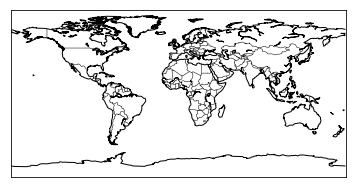

In [55]:
#################################################################
#############          Plot boundaries           ################
#################################################################

##############---->>> DEFINE THESE BEFORE RUNNING:
units        = ''
title        = 'Testing'
anno_text    = ''
file         = 'plotzz'
##############---->>> COOL, NOW RUN

colors_1 = [[0, '#171c42'], [0, '#263583'], [0, '#1a58af'], [0, '#1a7ebd'], [0, '#619fbc'], [0, '#9ebdc8'], [0, '#d2d8dc'], [0, '#e6d2cf'], [0, '#daa998'], [0, '#cc7b60'], [0, '#b94d36'], [0, '#9d2127'], [0, '#6e024']]
colors_2 = [[1, '#263583'], [1, '#1a58af'], [1, '#1a7ebd'], [1, '#619fbc'], [1, '#9ebdc8'], [1, '#d2d8dc'], [1, '#e6d2cf'], [1, '#daa998'], [1, '#cc7b60'], [1, '#b94d36'], [1, '#9d2127'], [1, '#6e0e24'], [1, '#3c0911']]

traces = Contour(
    z=hadley_evo[0,:,:],
    x=lon,
    y=lat,
    colorscale = [colors_1[0],colors_2[1]],# [0.15384615384615385, '#1a58af'], [0.23076923076923078, '#1a7ebd'], [0.3076923076923077, '#619fbc'], [0.38461538461538464, '#9ebdc8'], [0.46153846153846156, '#d2d8dc'], [0.5384615384615384, '#e6d2cf'], [0.6153846153846154, '#daa998'], [0.6923076923076923, '#cc7b60'], [0.7692307692307693, '#b94d36'], [0.8461538461538461, '#9d2127'], [0.9230769230769231, '#6e0e24'], [1.0, '#3c0911']],
    zauto=True,  # custom contour levels#
#     zmax=72,      # first contour level
#     zmin= 0,      # last contour level  => colorscale is centered about 0
   
 
# colorbar= {
#     "borderwidth": 0, 
#     "outlinewidth": 0, 
#     "thickness": 15, 
#     "tickfont": {"size": 14}, 
#     "title": units}, #gives your legend some units                                                                     

contours= dict(
    coloring='lines',
    start = 0,
    size = 1,
    end = 72, 
    showlines = False, 

)       
)   

traces = [traces]

#add other traces to base trace 
for i in range(1,hadley_evo.shape[0]):
            
    color_index = np.ceil(i*2.5)-1
    
    print(color_index)

    temp_trace = Contour(
    z=hadley_evo[i,:,:],
    x=lon,
    y=lat,
    colorscale = [colors_1[int(color_index)],colors_2[int(color_index)]],
    zauto=True,  # custom contour levels
    #     zmax=10,      # first contour level
    #     zmin=-10,     # last contour level  => colorscale is centered about 0


#     colorbar= {
#         "borderwidth": 0, 
#         "outlinewidth": 0, 
#         "thickness": 15, 
#         "tickfont": {"size": 14}, 
#         "title": units}, #gives your legend some units                                                                     

    contours= dict(
        coloring='lines',
        end = 72, 
        size = i+1, #this is your contour interval
        start = 0
    )       
    )  
    traces = traces + [temp_trace]
    
    temp_traces = None
    

#make shortcut to basemap object 
m = Basemap()

def make_scatter(x,y):
    return Scatter(
        x=x,
        y=y,
        mode='lines',
        line=Line(color="black"),
        name=' ')

#functions converting coastline/country polygons to lon/lat traces
def polygons_to_traces(poly_paths, N_poly):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    # init. plotting list
    data = dict(
        x=[],
        y=[],
        mode='lines',
        line=Line(color="black"),
        name=' '
    )

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)]
        )
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
    
        
        # add plot.ly plotting options
        data['x'] = data['x'] + lon_cc.tolist() + [np.nan]
        data['y'] = data['y'] + lat_cc.tolist() + [np.nan]
        
        # traces.append(make_scatter(lon_cc,lat_cc))
     
    return [data]


def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths() # coastline polygon paths
    N_poly = 91  # use only the 91st biggest coastlines (i.e. no rivers)
    return polygons_to_traces(poly_paths, N_poly)

# Function generating country lon/lat traces
def get_country_traces():
    poly_paths = m.drawcountries().get_paths() # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    return polygons_to_traces(poly_paths, N_poly)

# Get list of of coastline, country, and state lon/lat traces
traces_cc = get_coastline_traces()+get_country_traces()

data = Data(traces+traces_cc)

axis_style = dict(
    zeroline=False,
    showline=False,
    showgrid=False,
    ticks='',
    showticklabels=False,
)

layout = Layout(
    title=title,
    showlegend=False,
    hovermode="closest",        # highlight closest point on hover
    xaxis=XAxis(
        axis_style,
        range=[lon[0],lon[-1]]  # restrict y-axis to range of lon
    ),
    yaxis=YAxis(
        axis_style,
    ),
    annotations=Annotations([
        Annotation(
            text=anno_text,
            xref='paper',
            yref='paper',
            x=0,
            y=1,
            yanchor='bottom',
            showarrow=False
        )
    ]),
    autosize=False,
    width=1200,
    height=800,
)
fig = Figure(data=data, layout=layout)

py.iplot(fig, filename=file, width=1000)

In [202]:
lat[:10]

masked_array(data=[-90.0, -87.5, -85.0, -82.5, -80.0, -77.5, -75.0, -72.5,
                   -70.0, -67.5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=9.96921e+36,
            dtype=float32)